# Exercises - GEO4902-01 - General modeling concepts

Kjersti Stangeland, Fall 2024

# Exercise 01A - How to access the latest weather forecast:

In [1]:
# import python packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy as cy
from matplotlib.dates import DateFormatter
import netCDF4
import matplotlib.pyplot as plt
import numpy as np 
import metpy
import windrose
from metpy.calc import wind_speed, wind_direction
import cmocean.cm as cmo


##### Specify the file on the thredds server. For example the full file of latest forecast of the AROME Arctic weather model. Note, at this point only metadata is retrieved

In [2]:
url = 'https://thredds.met.no/thredds/dodsC/aromearcticlatest/latest/arome_arctic_lagged_12_h_latest_2_5km_latest.nc'
dataset = xr.open_dataset(url, engine='netcdf4')

### Metadata

In [3]:
dataset

<xarray.Dataset> Size: 10GB
Dimensions:                    (time: 58, ensemble_member: 4, pressure: 2,
                                height_above_msl: 1, height0: 1, height1: 1,
                                height2: 1, x: 739, y: 949)
Coordinates:
  * time                       (time) datetime64[ns] 464B 2024-09-13T12:00:00...
  * ensemble_member            (ensemble_member) int16 8B 0 1 2 3
  * pressure                   (pressure) float32 8B 850.0 925.0
  * height_above_msl           (height_above_msl) float32 4B 0.0
  * height0                    (height0) float32 4B 2.0
  * height1                    (height1) float32 4B 0.0
  * height2                    (height2) float32 4B 10.0
  * x                          (x) float32 3kB 2.786e+05 2.811e+05 ... 2.124e+06
  * y                          (y) float32 4kB -8.98e+05 ... 1.472e+06
    longitude                  (y, x) float64 6MB ...
    latitude                   (y, x) float64 6MB ...
Data variables: (12/15)
    forecast_reference_time    datetime64[ns] 8B ...
    projection_lambert         int32 4B ...
    x_wind_pl                  (time, pressure, ensemble_member, y, x) float32 1GB ...
    y_wind_pl                  (time, pressure, ensemble_member, y, x) float32 1GB ...
    air_temperature_pl         (time, pressure, ensemble_member, y, x) float32 1GB ...
    air_temperature_2m         (time, height0, ensemble_member, y, x) float32 651MB ...
    ...                         ...
    cloud_area_fraction        (time, height1, ensemble_member, y, x) float32 651MB ...
    air_pressure_at_sea_level  (time, height_above_msl, ensemble_member, y, x) float32 651MB ...
    precipitation_amount_acc   (time, height1, ensemble_member, y, x) float32 651MB ...
    snowfall_amount_acc        (time, height1, ensemble_member, y, x) float32 651MB ...
    wind_speed_of_gust         (time, height2, ensemble_member, y, x) float32 651MB ...
    fog_area_fraction          (time, height1, ensemble_member, y, x) float32 651MB ...
Attributes: (12/23)
    Conventions:                     CF-1.6, ACDD
    institution:                     Norwegian Meteorological Institute, MET ...
    institution_short_name:          NO/MET
    creator_url:                     met.no
    source:                          AROME-Arctic 2.5km
    title:                           AROME_Arctic 2.5km
    ...                              ...
    dataset_production_status:       Active
    iso_topic_category:              climatologyMeteorologyAtmosphere
    spatial_representation:          grid
    naming_authority:                no.met
    history:                         2024-09-13T14:23:45 creation by fimex
    DODS_EXTRA.Unlimited_Dimension:  time

__What is metadata and why is it important?__

Metadata is often attached to datasets and provide information about the outputs, which in our case is from a model. From metadata you get an overview of the contents, with descriptions of the grid, time steps, data variables available, dimensions of the model output and so on. Metadata is then data about the data. It is important because it helps us interpret the data and obtain useful information about how for instance the data variables are related to the grid-points of the model, or how large the model domain is. It simplifies reading the data, as it is labeled and organized. In addition to that you can read in the metadata who has provided the output, name of model, licenses an conventions used for names. Such things important for reproducible science and integrity. :)

### Find a specific point and plot the forecast. 
###### Note AROME Arctic is on an irregular grid, so the xarray.sel functionality does not work:

In [4]:
# Function to find a specific lat/lon location 

def findindex(alat,alon,plat,plon):
    # finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    x, y = np.where(c == np.min(c))
    # print(alats[x,y],alon[x,y])
    x=int(x)
    y=int(y)
   
    return (x,y)

In [5]:
# Find a specific location, for example for Barentsburg

lon = 14.2110; lat= 78.0650
[xloc,yloc] = findindex(dataset.latitude, dataset.longitude, lat, lon) 

t2m_point = dataset.air_temperature_2m[:,0,1,xloc,yloc]

print('longitude =', float(dataset.longitude[xloc,yloc].values.round(2)))
print('latitude =', float(dataset.latitude[xloc,yloc].values.round(2)))

# Note the number of dimentsions of the temperature array and cross-check with the metadata

longitude = 14.18
latitude = 78.06


/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_46890/3006826606.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x=int(x)
/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_46890/3006826606.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y=int(y)


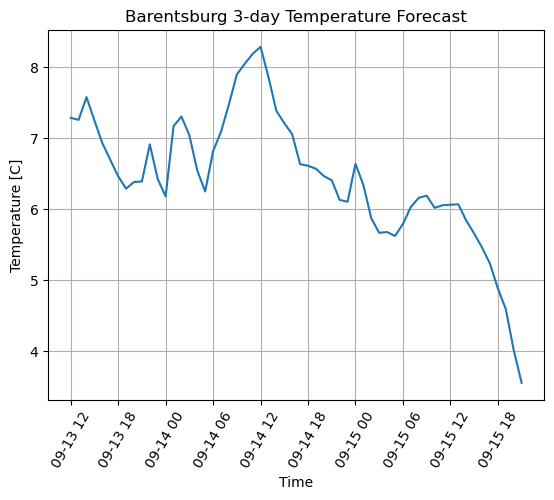

In [6]:
plt.plot(dataset.time, t2m_point - 273.15, '-')

plt.title("Barentsburg 3-day Temperature Forecast")
plt.ylabel('Temperature [C]')
plt.xticks(rotation=60)
plt.xlabel('Time')
plt.grid()
plt.show()

### Plot one forecast on a map

#### Choose ensemble member and timestep 

In [7]:
ensemble_mem = 1
timestep = 8

t2m_area = dataset.air_temperature_2m[timestep, 0, ensemble_mem, :, :]

Text(0.5, 0.98, 'Temperature forecast of Barentsburg at 2024-09-13T20:00:00.000000000')

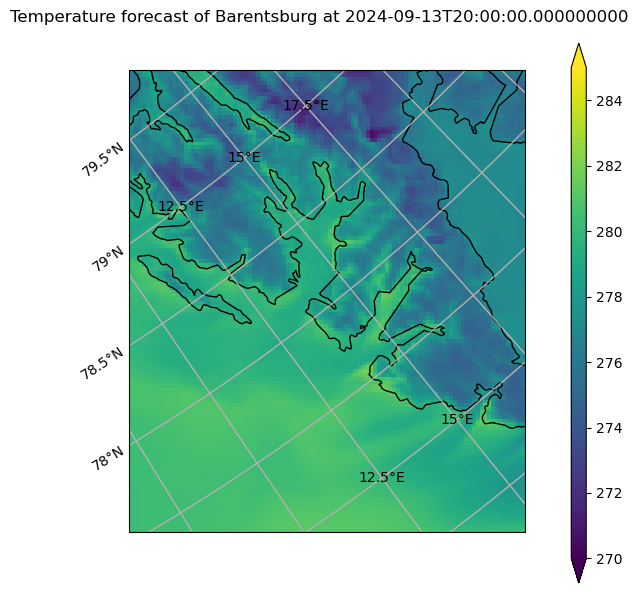

In [8]:
projection = cy.crs.LambertConformal(central_longitude = dataset.projection_lambert.longitude_of_central_meridian,
                                       central_latitude  = dataset.projection_lambert.latitude_of_projection_origin,
                                       standard_parallels = dataset.projection_lambert.standard_parallel)
fig = plt.figure(figsize=[6, 6])

ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([lon - 1.5, lon + 1.5, lat-1.5, lat+1.5], cy.crs.PlateCarree())

ax.gridlines()
ax.add_feature(cy.feature.COASTLINE, zorder=2) 
cf = ax.pcolormesh(t2m_area.longitude, t2m_area.latitude, t2m_area[:,:], transform=cy.crs.PlateCarree(), zorder=1)
cf.set_clim(270, 285)
gl = ax.gridlines(draw_labels=True)
gl.top_labels   = False
gl.right_labels = False
   
cbaxes = fig.add_axes([0.92, 0.025, 0.025, 0.9])
cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.5, orientation='vertical', extend='both')

fig.suptitle(f'Temperature forecast of Barentsburg at {t2m_area.time.values}')

In [9]:
# Retrieving wanted variables for forecast

t2m_point = dataset.air_temperature_2m[:,0,1,xloc,yloc]
ps_point = dataset.air_pressure_at_sea_level[:,0,1,xloc,yloc]
windgust_point = dataset.wind_speed_of_gust[:,0,1,xloc,yloc]
precip_point = dataset.precipitation_amount_acc[:,0,1,xloc,yloc]

Text(0.5, 0.98, 'Forecasted weather variables for Barentsburg')

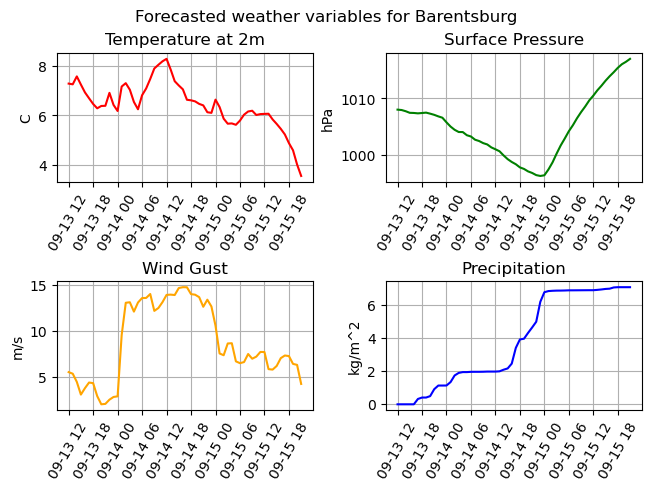

In [10]:
# plot time evolution of surface pressure, temperature, wind speed, precipitation
fig, axs = plt.subplots(2,2, constrained_layout=True)
axs[0, 0].plot(t2m_point.time, t2m_point.values - 273.15, color = 'red')
axs[0, 1].plot(t2m_point.time, ps_point.values/100, color = 'green')
axs[1, 0].plot(t2m_point.time, windgust_point.values, color = 'orange')
axs[1, 1].plot(t2m_point.time, precip_point.values, color = 'blue')

axs[0, 0].set_title('Temperature at 2m')
axs[0, 1].set_title('Surface Pressure')
axs[1, 0].set_title('Wind Gust')
axs[1, 1].set_title('Precipitation')

axs[0, 0].set_ylabel('C')
axs[0, 1].set_ylabel('hPa')
axs[1, 0].set_ylabel('m/s')
axs[1, 1].set_ylabel('kg/m^2')

for ax in axs.flat:
    ax.tick_params(axis = 'x', rotation = 60)
    ax.grid(True)

fig.suptitle('Forecasted weather variables for Barentsburg')

According to AROME 2.5 km and the chosen ensemble member, the weather of Barentsburg is forecasted to be quite windy, with some precipitation. The temperature will drop the coming days, with a decrease of 4 degrees celcius. The surface pressure will drop tomorrow, but increase on sunday. The drop in pressure could be due to a passing low pressure system, and then precipitation would be expected.  The increase in wind gusts saturday could be related to the drop in pressure. The timing of the precipitation also corrspond to the time of pressure drop. 

__Compared to yr.no__:
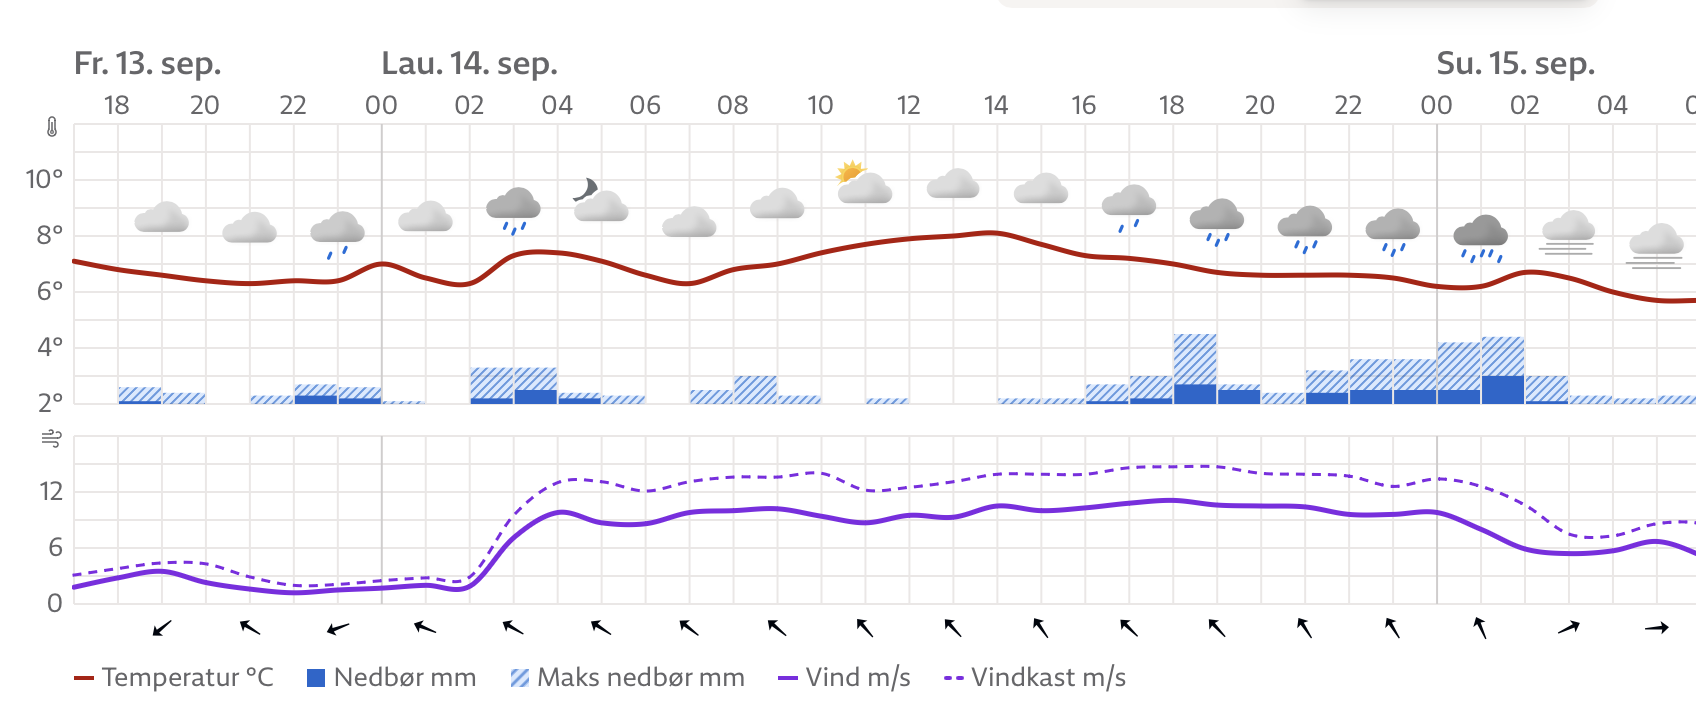

Yr also seems to capture the increase of wind gusts on saturday, and also detects incoming precipitation for Barentsburg. The temperature drop seen at yr.no is not as drastic as the one above. This can be due to my forecast only using a single ensemble member. 


In [11]:
wind_x = dataset.x_wind_10m[:, 0, 0, xloc, yloc]
wind_y = dataset.y_wind_10m[:, 0, 0, xloc, yloc]

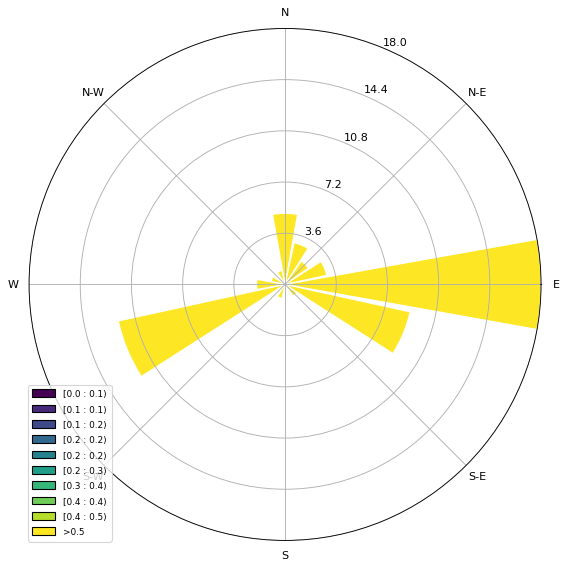

In [12]:
# Get the speed and direction of the winds
unit = metpy.units.units('m/s')
speed = np.squeeze(metpy.calc.wind_speed(wind_x.values*unit, wind_y.values*unit))
direction = np.squeeze(metpy.calc.wind_direction(wind_x.values*unit, wind_y.values*unit, convention='from'))

deg = np.array(np.round(direction, 1))
spd = np.array(np.round(speed, 2))

ax = windrose.WindroseAxes.from_ax()
ax.bar(deg, spd, opening = 0.9, edgecolor = 'white', bins = np.arange(0, 0.5, 0.05))
ax.set_legend()

I also added a windrose for fun to see the direction of the winds in Barentsburg. The coming 3-days they will have winds from the east. 

In [13]:
# I couldnt access AROME archive, so I used MEPS
url2 = 'https://thredds.met.no/thredds/dodsC/mepsoldarchive/2020/02/04/meps_subset_2_5km_20200204T00Z.nc'

ds = xr.open_dataset(url2)

### Point forecast Tromso, 04.02.2020 00:00 UTC

In [14]:
# Lat/lon of Tromsø
lat, lon = 69.6492 , 18.9560

# Find a specific location,

[xloc,yloc] = findindex(ds.latitude, ds.longitude, lat, lon) 

print('longitude =', float(ds.longitude[xloc,yloc].values.round(2)))
print('latitude =', float(ds.latitude[xloc,yloc].values.round(2)))

longitude = 18.98
latitude = 69.62


/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_46890/3006826606.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x=int(x)
/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_46890/3006826606.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y=int(y)


In [15]:
tromso_T2m = ds.air_temperature_2m[:, 0, 0, yloc, xloc]
tromso_windgust = ds.wind_speed_of_gust[:, 0, 0, yloc, xloc]

Text(0.5, 0.98, 'Point forecast Tromsø, February 2020')

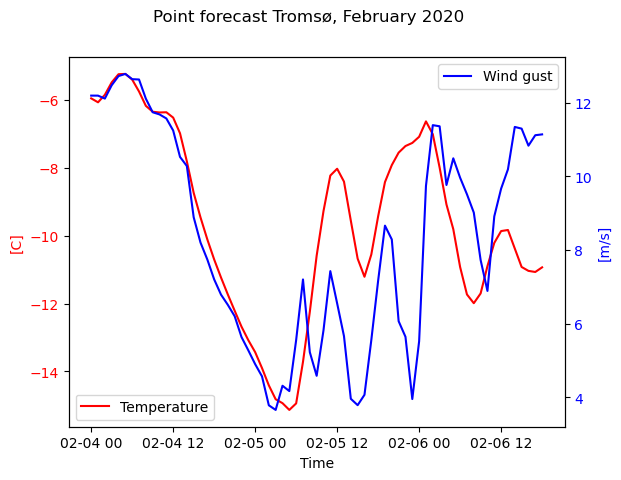

In [16]:
fig, ax = plt.subplots()

ax.plot(tromso_T2m.time, tromso_T2m.values - 273.15, label = 'Temperature', color = 'red')
ax.set_xlabel('Time')
ax.set_ylabel('[C]', color='r') 
ax.tick_params(axis='y', labelcolor='r') 

ax1 = ax.twinx()
ax1.plot(tromso_T2m.time, tromso_windgust.values, label = 'Wind gust', color = 'blue')
ax1.set_ylabel('[m/s]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax.legend(loc='lower left')
ax1.legend(loc = 'upper right')

fig.suptitle('Point forecast Tromsø, February 2020')

### Area forecast 4th of February 2020 14:00

In [17]:
# Find index of wanted time
ds = ds.sel(time = '2020-02-04T14:00:00.000000000')

In [18]:
# Temp. and wind forecast map, 04.02.2020 14:00 UTC

t2m_area = ds.air_temperature_2m[0, ensemble_mem, :, :]
windx_area = ds.x_wind_10m[0, ensemble_mem, :, :]
windy_area = ds.y_wind_10m[0, ensemble_mem, :, :]

Text(0.5, 0.98, 'Temperature and wind forecast for Tromsø February 4th 2020 at 14:00')

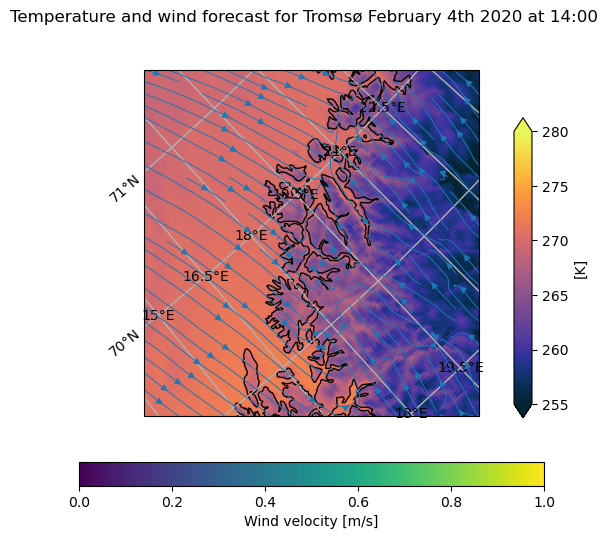

In [19]:
projection = cy.crs.LambertConformal(
    central_longitude=dataset.projection_lambert.longitude_of_central_meridian,
    central_latitude=dataset.projection_lambert.latitude_of_projection_origin,
    standard_parallels=dataset.projection_lambert.standard_parallel
)
fig = plt.figure(figsize=[6, 6])

ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([lon - 1.5, lon + 1.5, lat - 1.5, lat + 1.5], cy.crs.PlateCarree())

ax.gridlines()
ax.add_feature(cy.feature.COASTLINE, zorder=2)

cf = ax.pcolormesh(t2m_area.longitude, t2m_area.latitude, t2m_area[:, :], transform=cy.crs.PlateCarree(), cmap=cmo.thermal, zorder=1)
cf.set_clim(255, 280)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

cbaxes = fig.add_axes([0.85, 0.30, 0.03, 0.5])
cbar = plt.colorbar(cf, cax=cbaxes, orientation='vertical', extend='both')
cbar.set_label('[K]')

sp = ax.streamplot(ds.longitude, ds.latitude, windx_area, windy_area, transform=cy.crs.PlateCarree(), cmap=cmo.speed, linewidth=0.7)
cbar_stream = plt.colorbar(sp.lines, ax=ax, orientation='horizontal', pad=0.1, label='Wind velocity [m/s]')

fig.suptitle('Temperature and wind forecast for Tromsø February 4th 2020 at 14:00')


* Plot the temperature and wind forecast from AROMEArctic as a map for 2020 February 04 14:00 UTC. And a point-forecast initialized on 2020 February 04 00:00 UTC  for Tromsø. The forecast date is related to a polar low which made landfall in 2020 directly at Tromsø. 